In [ ]:
# this file is to prepare density map of gt using geometry-adaptive which takes around 2 hours

In [ ]:
# file ni pakai geo_adaptive so make sure pakai gaussian mana dulu !!!

In [3]:
!pip install opencv-python-headless torchvision h5py scipy numpy matplotlib image scikit-image

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 32.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 69.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 30.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 52.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.4 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 41.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 40.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 7.9 MB/s eta

In [5]:
import os
import glob
import json
import numpy as np
import scipy
import scipy.io as io
import h5py
from scipy.ndimage import gaussian_filter
import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import torch
import importlib
import model
importlib.reload(model)
from model import CSRNet
from image import *

%matplotlib inline

In [7]:
# checking
print(cv2.__version__)
print(torch.__version__)
print(torch.rand(2, 3))
print(dir(model))

4.11.0
2.7.0+cu126
tensor([[0.7424, 0.2004, 0.8229],
        [0.9585, 0.4475, 0.4451]])
['CSRNet', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'load_net', 'make_layers', 'models', 'nn', 'save_net', 'torch']


In [8]:
!pip install kagglehub

import kagglehub
path = kagglehub.dataset_download("tthien/shanghaitech")

print("Path to dataset files:", path)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 12.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 25.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 333M/333M [00:37<00:00, 9.32MB/s] 

Extracting files...


Path to dataset files: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1


In [9]:
root = '/home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/'

In [10]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')

path_setA = [part_A_train,part_A_test]

In [11]:
#loop all dataset

import re
def sort_by_number(path):
    filename = os.path.basename(path)
    number = int(re.findall(r'\d+', filename)[0])
    return number


img_paths_A_train = sorted(glob.glob(os.path.join(part_A_train, '*.jpg')), key=sort_by_number)
img_paths_A_test  = sorted(glob.glob(os.path.join(part_A_test, '*.jpg')), key=sort_by_number)
img_paths_A = img_paths_A_train + img_paths_A_test
print(f"{len(img_paths_A)} images in Part A")

print(f"Total images: {len(img_paths_A)}")

482 images in Part A
Total images: 482


In [12]:
#lets start! we will use geo-adaptive_gaussian

In [13]:
# Geometry-Adaptive Gaussian: using one local Gaussian blur per head

#there is N gaussian blur->slow

# inspired from https://github.com/davideverona/deep-crowd-counting_crowdnet
def geoadaptive_gaussian(gt):
    print (gt.shape)#takes a 2d binary with 1s marking head positions
    density = np.zeros(gt.shape, dtype=np.float32)

    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    #find all coordinates where gt[y,x]==1 and turn into list of tuples (x,y)


    # build kdtree for nearest neighbour search
    # for each headpoint, query its 3 neighbours (exc itself)
    # which are distances[i][1], distances[i][2], distances[i][3].

    leafsize = 2048  #larger leafsize reduces the tree's depth for faster query
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    distances, locations = tree.query(pts, k=4)
    print ('generate density...')


    # loop over each head and generate its density
    # create a blank image, then set the value to 1 at that head’s location.
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1. #pt[1] is y, pt[0] is x

        if gt_count > 1:
            # compute adaptive part
            # calc sigma based on avg distance to the 3 nearest neighbours and scale w 0.1
            #sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
            sigma = np.mean(distances[i][1:4]) * 0.3

        else:
            sigma = np.average(np.array(gt.shape))/4. # asign default sigma

        #apply gausian blur on single-point image and add to total density maps
        density += scipy.ndimage.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density


#add up all the blurry circles into one final heatmap

In [14]:


total = len(img_paths_A)
for idx, img_path in enumerate(img_paths_A):
    print(f"[A {idx+1}/{total}] Processing: {img_path}")

    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img = plt.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = geoadaptive_gaussian(k)

    h5_path_A = img_path.replace('.jpg','.h5').replace('images','generated-h5')
    os.makedirs(os.path.dirname(h5_path_A), exist_ok=True)
    
   # if os.path.exists(h5_path):
   #     os.remove(h5_path)
   #     print(f"Deleted existing file: {h5_path}")
        
    with h5py.File(h5_path_A, 'w') as hf:
        hf['density'] = k

[A 1/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_1.jpg
(768, 1024)
generate density...
done.
[A 2/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_2.jpg
(713, 1024)
generate density...
done.
[A 3/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_3.jpg
(664, 1000)
generate density...
done.
[A 4/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_4.jpg
(746, 1024)
generate density...
done.
[A 5/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/train_data/images/IMG_5.jpg
(683, 1024)
generate density...
done.
[A 6/482] Processing: /home/elicer/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_

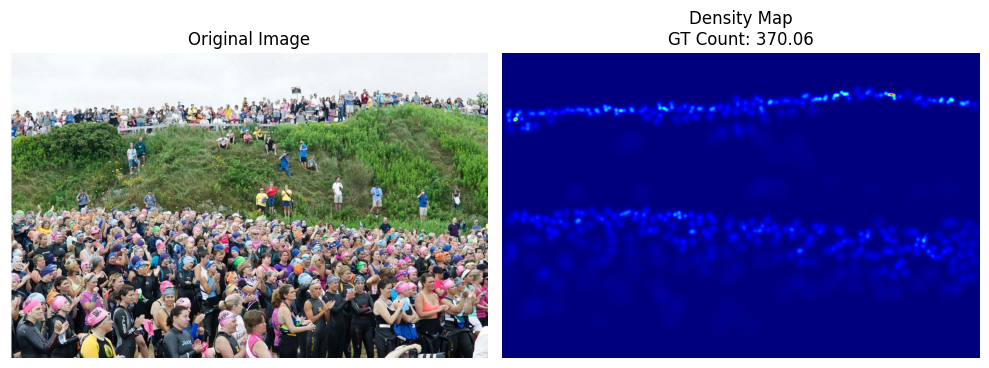

In [32]:
#checking one image
img_test = img_paths_A[99]

imgg= cv2.imread(img_test)
imgg = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)

h5_path_test = img_test.replace('.jpg','.h5').replace('images','generated-h5')
with h5py.File(h5_path_test, 'r') as hf:
    density_map_test = np.asarray(hf['density'])


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(imgg)
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2) 
plt.imshow(density_map_test, cmap=CM.jet)
plt.axis('off')
plt.title(f'Density Map\nGT Count: {density_map_test.sum():.2f}')
plt.tight_layout()
plt.show()

In [17]:
img_test = img_paths_A[99]
mat_test = img_test.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_')

matt_test = io.loadmat(mat_test)
gt_test = matt_test["image_info"][0, 0][0, 0][0]

actual_count = len(gt_test)
print(f"Actual number of people in the image: {actual_count}")

Actual number of people in the image: 371


In [ ]:
#check if they all got .h5 files

In [25]:
missing_h5 = []

for img_path in img_paths_A:
    #get expected .h5 path
    h5_path = img_path.replace('.jpg', '.h5').replace('images', 'generated-h5')
    
    if not os.path.exists(h5_path):
        missing_h5.append(h5_path)

if missing_h5:
    print(f"Missing {len(missing_h5)} .h5 files:")
    for path in missing_h5[:10]:  # show only first 10
        print("  -", path)
else:
    print("All .h5 files are present for every image.")

All .h5 files are present for every image.


In [ ]:
#creating json files

In [20]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 51.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 59.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [21]:
from sklearn.model_selection import train_test_split

subset_img_paths = sorted(img_paths_A)

# split into 80% train, 20% val
train_paths, val_paths = train_test_split(subset_img_paths, test_size=0.2, random_state=42)

def create_json(img_paths, json_path):
    with open(json_path, 'w') as f:
        json.dump(img_paths, f, indent=2)
    print(f"Saved JSON to: {json_path}")

create_json(train_paths, "A_train.json")
create_json(val_paths, "A_val.json")


Saved JSON to: A_train.json
Saved JSON to: A_val.json


In [22]:
#to count images
with open("A_train.json", "r") as f:
    train_data = json.load(f)

with open("A_val.json", "r") as f:
    val_data = json.load(f)

print("Number of training images:", len(train_data))
print("Number of validation images:", len(val_data))


Number of training images: 385
Number of validation images: 97
